## Marginal vs multicontext effect sign heatmap
Author: Anqi Wang and Jenny Empawi

#### Load libraries

In [17]:
library(ggplot2)
library(reshape2)
library(stringr)
library(dplyr)
library(data.table)
library(tidyverse)

### Marginal Posterior Effect Sign

In [18]:
posterior_dat <-readRDS("/restricted/projectnb/xqtl/jaempawi/xqtl/mash_34_contexts_ed_bovy_1e3.EZ.posterior.rds") #FIXME
### transfer the lfsr to the four columns
posterior_dat_lfsr <- as.data.frame(posterior_dat$lfsr)%>%
                     mutate(
                             split_info = str_split(as.character(rownames(posterior_dat$lfsr)), "_", simplify = TRUE),
                             variant = split_info[, 1],
                             gene = split_info[, 2]
                           ) %>%
                     select(-split_info)%>%
                     pivot_longer(
                            cols = -c(variant, gene),  # Keep 'variant' and 'gene' columns fixed
                            names_to = "context",      # New column for context (column names)
                            values_to = "lfsr"  # New column for effect sizes (values)
                     ) 
rownames(posterior_dat_lfsr) <- NULL
posterior_dat_negative_prob <- as.data.frame(posterior_dat$NegativeProb)%>%
                     mutate(
                             split_info = str_split(as.character(rownames(posterior_dat$NegativeProb)), "_", simplify = TRUE),
                             variant = split_info[, 1],
                             gene = split_info[, 2]
                           ) %>%
                     select(-split_info)%>%
                     pivot_longer(
                            cols = -c(variant, gene),  # Keep 'variant' and 'gene' columns fixed
                            names_to = "context",      # New column for context (column names)
                            values_to = "prob"  # New column for effect sizes (values)
                     )
### transfer the posterior_mean to the four columns
posterior_dat_effect <- as.data.frame(posterior_dat$PosteriorMean)%>%
                     mutate(
                             split_info = str_split(as.character(rownames(posterior_dat$PosteriorMean)), "_", simplify = TRUE),
                             variant = split_info[, 1],
                             gene = split_info[, 2]
                           ) %>%
                     select(-split_info)%>%
                     pivot_longer(
                            cols = -c(variant, gene),  # Keep 'variant' and 'gene' columns fixed
                            names_to = "context",      # New column for context (column names)
                            values_to = "effect"  # New column for effect sizes (values)
                     )
posterior_dat_effect$effect_sign <- factor(posterior_dat_effect$effect > 0, 
                                           levels = c(FALSE, TRUE), 
                                           labels = c("-1", "+1"))
rownames(posterior_dat_effect) <- NULL
### integrate lfsr and effec, also effect sign
posterior_dat_lfsr_effect <- posterior_dat_lfsr%>%
                                left_join(posterior_dat_effect,by = c("variant","gene","context"))%>%
                                left_join(posterior_dat_negative_prob, by = c("variant","gene","context"))
lfsr_cutoff <- 0.01
posterior_dat_lfsr_effect_filtered <- posterior_dat_lfsr_effect%>%filter(lfsr<lfsr_cutoff)
ROSMAP_multicontext_top_loci <- fread("/Staging/variant_gene_summary/xQTL_loci_summary/xQTL_finemapping/multi_context_finemapping/ROSMAP.exported.toploci.bed.gz")
ROSMAP_multicontext_top_loci_pip_sum <- ROSMAP_multicontext_top_loci %>% group_by(gene_ID)%>% mutate(pip_sum = sum(PIP))
mvsusie_export_lfsr_integrated_df <- ROSMAP_multicontext_top_loci_pip_sum %>%
  separate_rows(event_ID, conditional_effect, lfsr, sep = ";")%>%
  mutate(
    effect_sign = case_when(
      conditional_effect > 0 ~ "+1",
      conditional_effect < 0 ~ "-1",
      conditional_effect == 0 ~ "0",
      TRUE ~ NA_character_  # handle any unexpected NAs
    )
  )
#mvsusie_export_lfsr_integrated_df <- readRDS("~/project/Figure_2b/multicontext_top_loci_integrated.rds")
traits <- as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%pull(event_ID)))
posterior_dat_lfsr_effect_filtered_context <- posterior_dat_lfsr_effect_filtered%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%
                                                                                           pull(gene_ID))))
posterior_dat_lfsr_effect_filtered_context_top_variants <- posterior_dat_lfsr_effect_filtered_context %>% 
                                                                group_by(gene, context) %>% 
                                                                filter(lfsr == min(lfsr),prob == max(prob)) %>%
                                                                ungroup() %>%
                                                                unique()

In [19]:
coverage <- "cs_coverage_0.95"
intersected_gene_names <- posterior_dat_lfsr_effect_filtered_context_top_variants%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%
                                                                                           filter(.data[[coverage]]!=0)%>%pull(gene_ID)))) %>% pull(gene)%>%unique()
length(intersected_gene_names)

[1] 7069

### Marginal trait matrix

In [20]:
#trait_matrix <- readRDS("~/project/Figure_2b/marginal_efect_sign_0429_4063.rds")
# replace with the new version multicontext top loci table
ROSMAP_multicontext_res <- fread("/Staging/variant_gene_summary/xQTL_loci_summary/xQTL_finemapping/multi_context_finemapping/ROSMAP.exported.toploci.bed.gz")
ROSMAP_multicontext_top_loci_pip_sum <- ROSMAP_multicontext_res%>% group_by(gene_ID)%>% mutate(pip_sum = sum(PIP))
mvsusie_export_lfsr_integrated_df <- ROSMAP_multicontext_top_loci_pip_sum %>%
  separate_rows(event_ID, conditional_effect, lfsr, sep = ";")%>%
  mutate(
    effect_sign = case_when(
      conditional_effect > 0 ~ "+1",
      conditional_effect < 0 ~ "-1",
      conditional_effect == 0 ~ "0",
      TRUE ~ NA_character_  # handle any unexpected NAs
    )
  )
# we split the event_ID in the multicontext top loci table to get `mvsusie_export_lfsr_integrated_df`
#mvsusie_export_lfsr_integrated_df <- readRDS("~/project/Figure_2b/multicontext_top_loci_integrated.rds")
traits <- as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%pull(event_ID)))
coverage <- "cs_coverage_0.95"
intersected_gene_names <- posterior_dat_lfsr_effect_filtered_context_top_variants%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%
                                                                                           filter(.data[[coverage]]!=0)%>%pull(gene_ID)))) %>% pull(gene)%>%unique()
ROSMAP_multicontext_extracted <- ROSMAP_multicontext_res %>% filter(event_ID!="") %>% filter(gene_ID%in%intersected_gene_names)
posterior_dat_lfsr_effect_filtered_context <- posterior_dat_lfsr_effect_filtered%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%unique(ROSMAP_multicontext_extracted$gene_ID))
posterior_dat_lfsr_effect_filtered_context_grouped <- posterior_dat_lfsr_effect_filtered_context %>%
  group_by(gene, variant) %>%
  summarise(
    contexts = paste(unique(context), collapse = ","), 
    .groups = "drop"
  )
num_traits <- length(traits)
trait_matrix <- matrix(0, nrow = num_traits, ncol = num_traits)  # Initialize matrix
rownames(trait_matrix) <- colnames(trait_matrix) <- traits   # Assign trait names
for (gene_name in unique(posterior_dat_lfsr_effect_filtered_context_grouped$gene)){
#gene_name <- as.character(unique(mvsusie_export_lfsr_integrated_df$gene))[1]
strong_variants_lfsr_thres <- posterior_dat_lfsr_effect_filtered_context_grouped %>%
  filter(gene == gene_name) %>%
  pull(variant)%>%
  unique()
#Iterate through variants in df2
for (variant_ID in strong_variants_lfsr_thres) {
  # Extract rows from df1 where the marker matches the variant in df2
  variant_data <- posterior_dat_lfsr_effect_filtered_context %>% filter(gene==gene_name)%>%filter(variant == variant_ID)
  # If variant is found in multiple traits, compare effect signs
  if (nrow(variant_data) > 1) {
    
    # Get unique trait pairs
    for (i in 1:(nrow(variant_data) - 1)) {
      for (j in (i + 1):nrow(variant_data)) {
        
        trait_i <- variant_data$context[i]
        trait_j <- variant_data$context[j]
        
        effect_sign_i <- variant_data$effect_sign[i]
        effect_sign_j <- variant_data$effect_sign[j]

        # Find indices in the trait matrix
        idx_i <- which(traits == trait_i)
        idx_j <- which(traits == trait_j)
        
        # Ensure idx_i is always smaller than idx_j for upper triangle updates
        if (idx_i > idx_j) {
              temp <- idx_i
              idx_i <- idx_j
              idx_j <- temp
        }

        # Update matrix correctly with only +1 increments
        if (effect_sign_i == effect_sign_j) {
            trait_matrix[idx_i, idx_j] <- trait_matrix[idx_i, idx_j] + 1  # Always upper triangle
        } else {
            trait_matrix[idx_j, idx_i] <- trait_matrix[idx_j, idx_i] + 1  # Always lower triangle
        }
      }
    }
  } else if (nrow(variant_data) == 1) {
    trait_idx <- which(traits == variant_data$context)
    trait_matrix[trait_idx, trait_idx] <- trait_matrix[trait_idx, trait_idx] + 1 # Diagonal increment
    } 
  }
}

trait_matrix

AC_DeJager_eQTL DLPFC_DeJager_eQTL PCC_DeJager_eQTL
AC_DeJager_eQTL       310            9786               10111           
DLPFC_DeJager_eQTL    324             126               10568           
PCC_DeJager_eQTL      116              88                  17           
Exc_mega_eQTL        1291             783                 837           
Ast_Kellis_eQTL       721             518                 602           
Ast_mega_eQTL         730             544                 627           
Exc_DeJager_eQTL     1237             742                 785           
Exc_Kellis_eQTL      1205             700                 784           
Inh_DeJager_eQTL     1128             779                 837           
Inh_Kellis_eQTL      1120             758                 838           
Inh_mega_eQTL        1150             811                 873           
Oli_DeJager_eQTL      843             677                 774           
Oli_mega_eQTL         868             700                 790           
Ast_DeJager_eQTL      733             538                 613           
OPC_Kellis_eQTL       897             704                 770           
Oli_Kellis_eQTL       895             681                 797           
DLPFC_Bennett_pQTL    293             270                 210           
OPC_DeJager_eQTL      798             650                 683           
OPC_mega_eQTL         826             683                 715           
monocyte_ROSMAP_eQTL  286             290                 284           
Mic_Kellis_eQTL       340             290                 302           
Mic_mega_eQTL         262             237                 236           
Mic_DeJager_eQTL      337             300                 302           
                     Exc_mega_eQTL Ast_Kellis_eQTL Ast_mega_eQTL
AC_DeJager_eQTL      5336          3626            3673         
DLPFC_DeJager_eQTL   6482          4010            4039         
PCC_DeJager_eQTL     6029          3615            3653         
Exc_mega_eQTL           2          3794            3852         
Ast_Kellis_eQTL       458             7            5458         
Ast_mega_eQTL         503             0               0         
Exc_DeJager_eQTL        1           456             494         
Exc_Kellis_eQTL         6           368             422         
Inh_DeJager_eQTL      175           324             351         
Inh_Kellis_eQTL       149           270             316         
Inh_mega_eQTL         188           327             361         
Oli_DeJager_eQTL      599           286             299         
Oli_mega_eQTL         592           287             310         
Ast_DeJager_eQTL      487             2               3         
OPC_Kellis_eQTL       322           130             143         
Oli_Kellis_eQTL       565           253             281         
DLPFC_Bennett_pQTL    588           397             429         
OPC_DeJager_eQTL      300           120             122         
OPC_mega_eQTL         308           134             141         
monocyte_ROSMAP_eQTL  375           219             223         
Mic_Kellis_eQTL       224           127             128         
Mic_mega_eQTL         168           126             125         
Mic_DeJager_eQTL      233           133             132         
                     Exc_DeJager_eQTL Exc_Kellis_eQTL Inh_DeJager_eQTL
AC_DeJager_eQTL      5836             5093            4655            
DLPFC_DeJager_eQTL   6984             6228            5352            
PCC_DeJager_eQTL     6561             5785            4972            
Exc_mega_eQTL        8974             8566            6617            
Ast_Kellis_eQTL      3658             3808            3614            
Ast_mega_eQTL        3717             3760            3656            
Exc_DeJager_eQTL        7             8335            6852            
Exc_Kellis_eQTL        16                6            6285            
Inh_DeJager_eQTL      153              148              11            

### Marginal posterior effect sign heatmap

In [21]:
# Ensure "AC_DeJager_eQTL" stays on top
#trait_matrix <- readRDS("~/project/Figure_2b/marginal_efect_sign_0429_4063.rds")
trait_matrix <- trait_matrix[order(factor(rownames(trait_matrix), levels = rownames(trait_matrix))), 
                           order(factor(colnames(trait_matrix), levels = rownames(trait_matrix)))]
rev_trait_matrix <- trait_matrix[,ncol(trait_matrix):1]
#rev_trait_matrix <- t(trait_matrix)
rev_trait_matrix <- t(rev_trait_matrix)

# Calculate the fraction matrix
# Assuming rev_trait_matrix is your input square matrix
context_names <- colnames(rev_trait_matrix)
n <- length(context_names)

# Initialize output matrix
proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(proportion_matrix) <- rownames(proportion_matrix) <- context_names 

pairwise_proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(pairwise_proportion_matrix) <- rownames(pairwise_proportion_matrix) <- context_names 

for (i in seq_len(n)) {
  for (j in seq_len(n)) {
    if (i != j) {
      # Extract 2x2 submatrix
      trait_i <- colnames(trait_matrix)[i]
      trait_j <- colnames(trait_matrix)[j]
      pattern <- pattern <- str_c(trait_i, trait_j, sep = "|")
      submat <- trait_matrix[c(i, j), c(i, j)]
      marginal_multicontext_res <-  posterior_dat_lfsr_effect_filtered_context_grouped %>%
                                        filter(str_detect(contexts,pattern)) %>% 
                                        unique() 
      pairwise_total_sum <- sum(submat) - sum(diag(submat))
      total_sum <- pairwise_total_sum +  nrow(marginal_multicontext_res)
      value <- trait_matrix[i, j]

      # Compute and assign proportion
      proportion_matrix[i, j] <- round((value / total_sum)*100, 2)
      pairwise_proportion_matrix[i, j] <- round((value / pairwise_total_sum)*100, 2)
    }
  }
}
# View or use proportion_matrix
#rev_proportion_matrix

rev_proportion_matrix <- proportion_matrix[, ncol(proportion_matrix):1]
rev_proportion_matrix <- t(rev_proportion_matrix)


# Convert matrix into long format for ggplot
plot_data <- reshape2::melt(rev_proportion_matrix)
colnames(plot_data) <- c("Trait1", "Trait2", "Count")

# 1. Identify which rows need filling
na_idx <- is.na(plot_data$Count)

# 2. Pull from the matrix by name for those rows
# Find numeric row/col indices
r <- match(plot_data$Trait1[na_idx], rownames(trait_matrix))
c <- match(plot_data$Trait2[na_idx], colnames(trait_matrix))

# Do element-wise lookup
plot_data$Count[na_idx] <- trait_matrix[cbind(r, c)]

#proportion_matrix
rev_pairwise_proportion_matrix <- pairwise_proportion_matrix[, ncol(pairwise_proportion_matrix):1]
rev_pairwise_proportion_matrix <- t(rev_pairwise_proportion_matrix)

 
plot_data$Fraction <- as.vector(reshape2::melt(rev_pairwise_proportion_matrix)$value)

#credible_sum <- posterior_dat_lfsr_effect_filtered_context_grouped %>% unique() %>%nrow()


plot_data <- plot_data %>%
  rowwise() %>%
  mutate(
    Label = if (!is.na(Fraction)) {
      paste0(Fraction, "\n(", Count, ")")
    } else {
      total_genes <- posterior_dat_lfsr_effect_filtered_context_grouped %>%
        filter(str_detect(contexts,as.character(Trait1))) %>%
        nrow()
      
      round((Count / total_genes) * 100, 2) %>% as.character()
    }
  ) %>%
  ungroup()
# df$Label <- ifelse(!is.na(df$Fraction), 
#                    paste0(df$Fraction, "\n(", df$Count, ")"), 
#                    as.character(round((df$Count/credible_sum)*100,2)))

plot_data$Trait1 <- factor(plot_data$Trait1, levels = rev(rownames(rev_proportion_matrix)))
plot_data$Trait2 <- factor(plot_data$Trait2, levels = rownames(rev_proportion_matrix))
# df$Trait1 <- factor(df$Trait1, levels = rev(rownames(rev_trait_matrix)))
# df$Trait2 <- factor(df$Trait2, levels = rownames(rev_trait_matrix))

In [22]:
#pdf("ROSMAP_marginal_effect_sign_heatmap_version_0429_4063.pdf", width =10, height = 8)
# Plot heatmap using ggplot2
p1 <- ggplot(plot_data, aes(x = Trait1, y = Trait2, fill = Fraction)) +
  geom_tile(color = "black") +
  scale_fill_gradient(low = "white", high = "red", na.value = "grey") +
  geom_text(aes(label = Label), size = 6) +  # Add text with count and fraction
  labs(x = "", y = "", fill = "Proportion", title = "Marginal Posterior Effect Sign Heatmap") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
        axis.text.y = element_text(size = 15),
        plot.title = element_text(hjust = 0.5, size = 25,face = "bold"),
        legend.title = element_text(size = 20,face = "bold"),
       legend.text = element_text(size = 15))

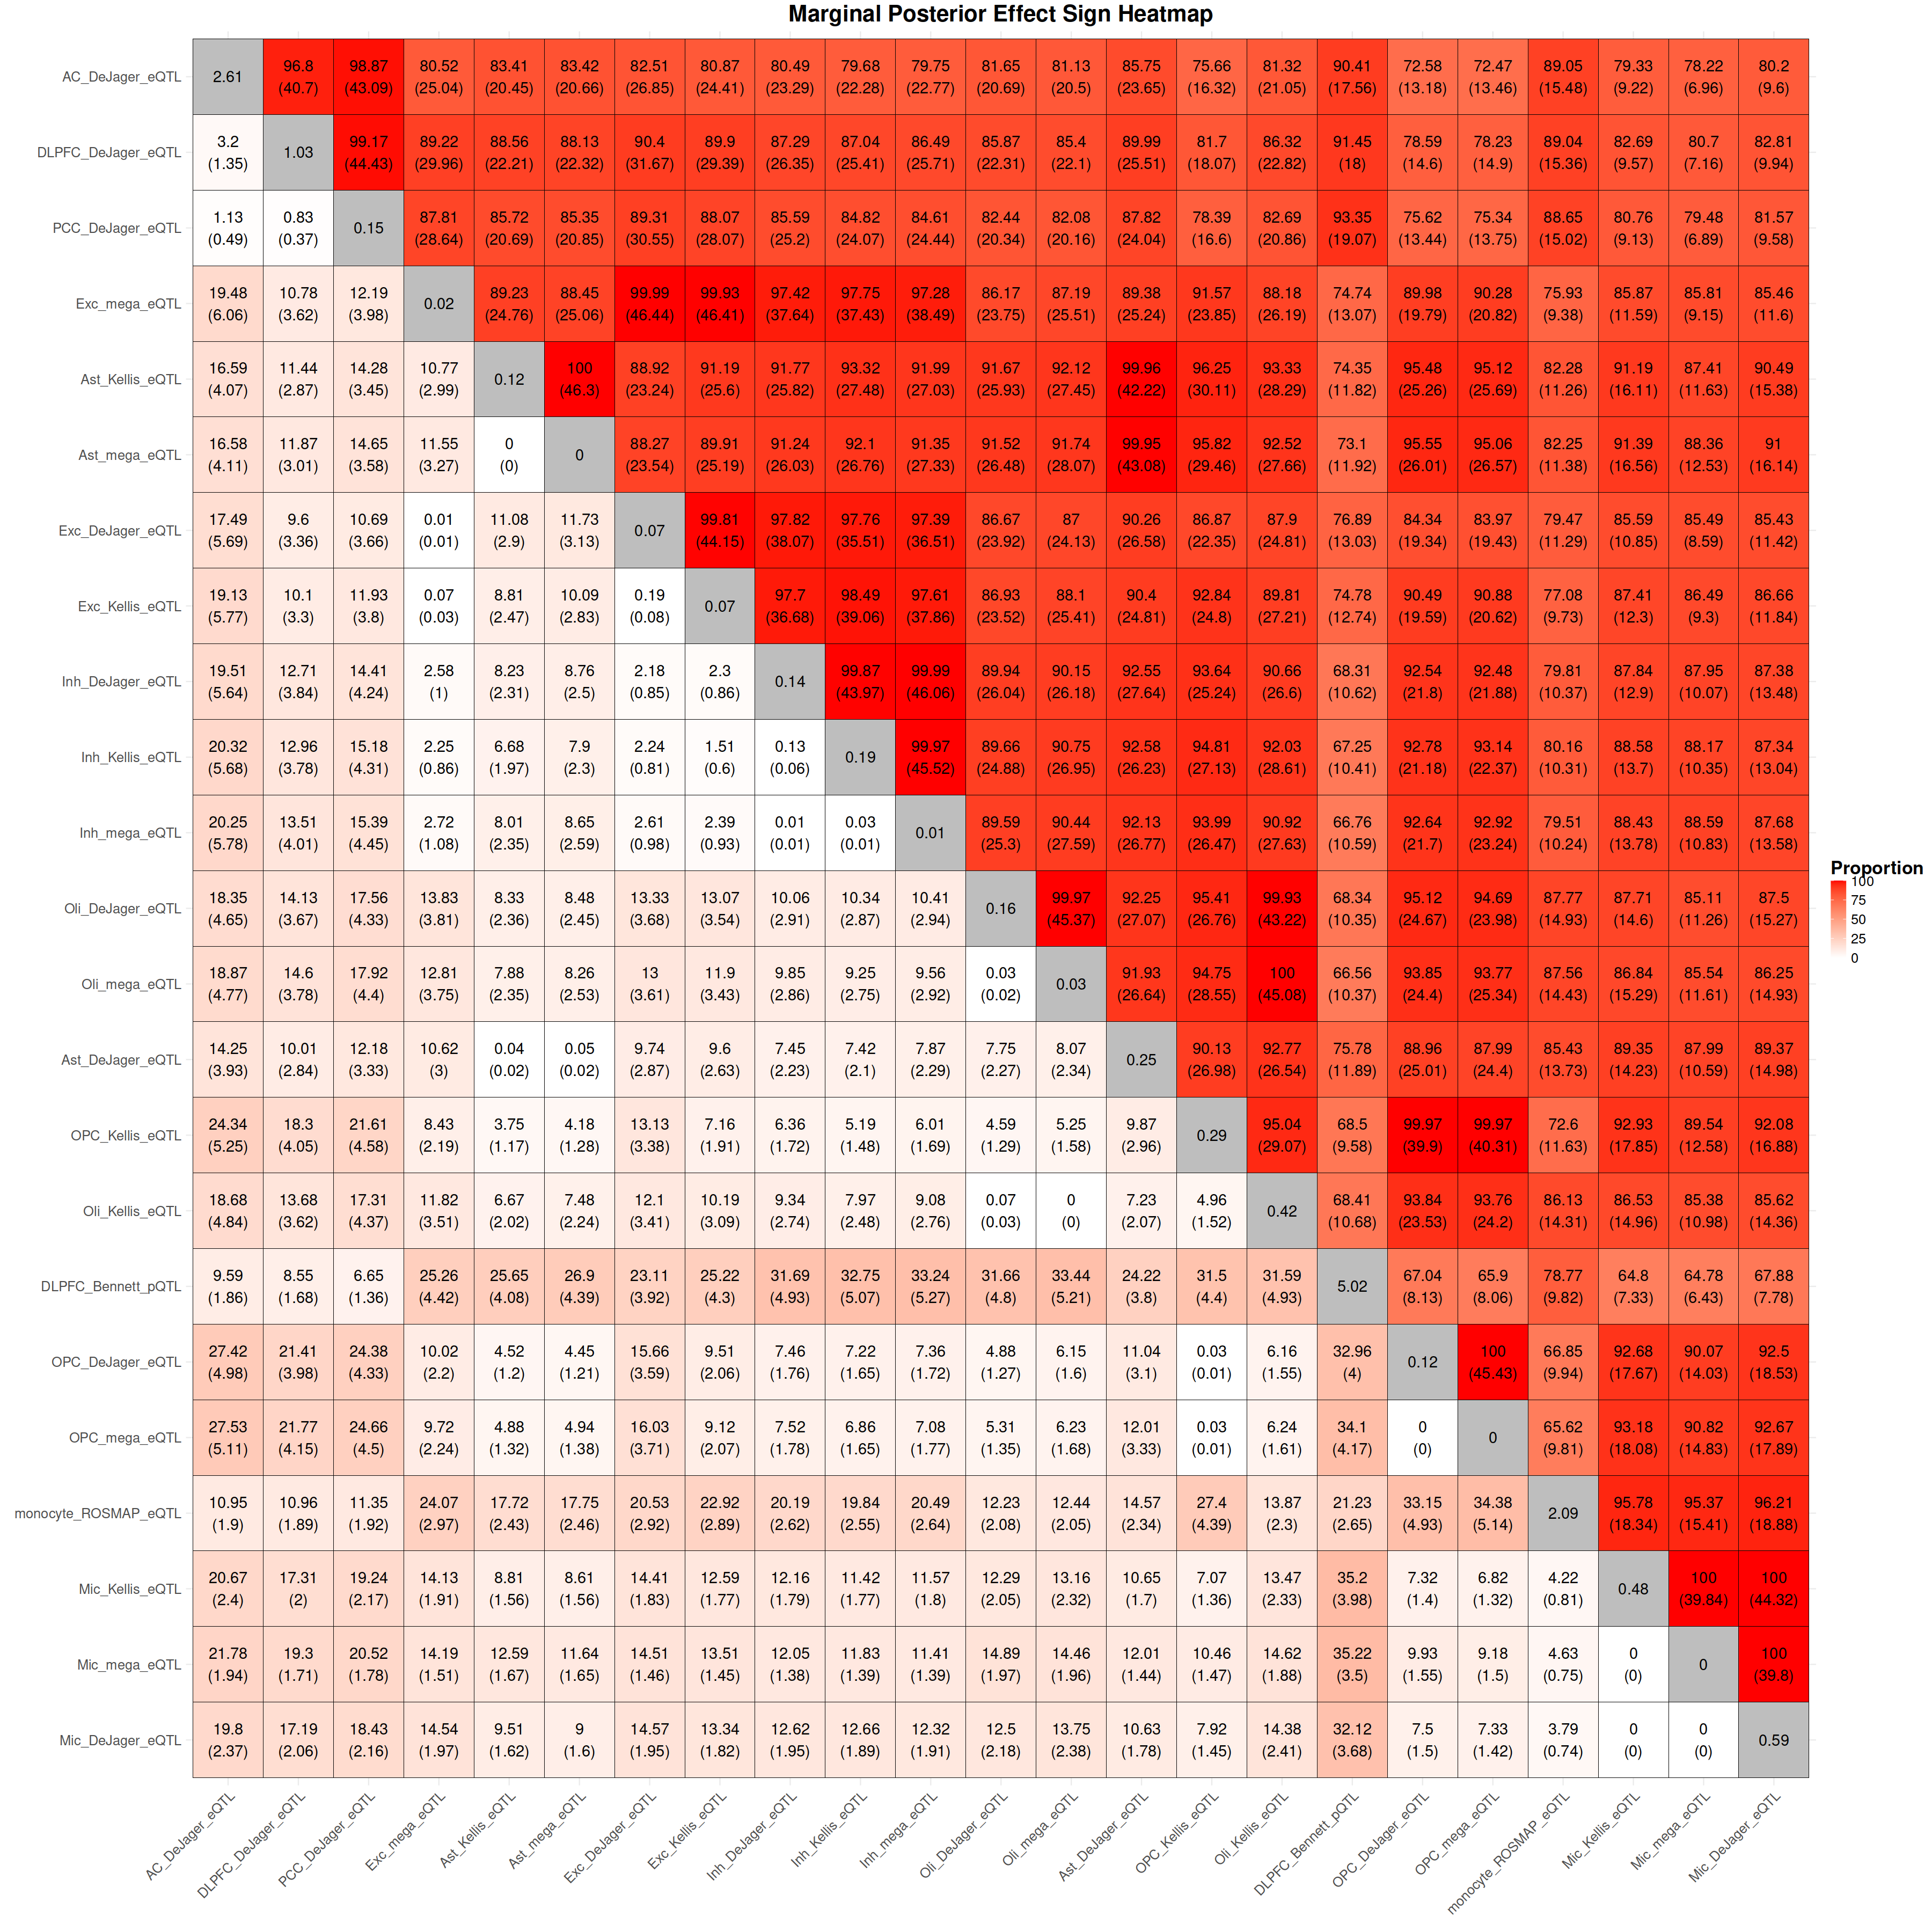

In [23]:
options(repr.plot.width = 30, repr.plot.height = 30)
p1

## Multicontext Effect Posterior Effect Sign

### Multicontext trait matrix

In [24]:
coverage <- "cs_coverage_0.95"
mvsusie_export_lfsr_integrated_df <- readRDS("/restricted/projectnb/xqtl/jaempawi/xqtl/Staging/variant_gene_summary/xQTL_loci_summary/xQTL_finemapping/multi_context_finemapping/consolidated/FunGen_xQTL_multi_context_top_loci_integrated.rds")
ROSMAP_multicontext_top_loci_pip_sum <- ROSMAP_multicontext_res%>% group_by(gene_ID)%>% mutate(pip_sum = sum(PIP))
mvsusie_export_lfsr_integrated_df <- ROSMAP_multicontext_top_loci_pip_sum %>%
  separate_rows(event_ID, conditional_effect, lfsr, sep = ";")%>%
  mutate(
    effect_sign = case_when(
      conditional_effect > 0 ~ "+1",
      conditional_effect < 0 ~ "-1",
      conditional_effect == 0 ~ "0",
      TRUE ~ NA_character_  # handle any unexpected NAs
    )
  )
traits <- as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%pull(event_ID)))
intersected_gene_names <- posterior_dat_lfsr_effect_filtered_context_top_variants%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%
                                                                                           filter(.data[[coverage]]!=0)%>%pull(gene_ID)))) %>% pull(gene)%>%unique()
ROSMAP_multicontext_extracted <- ROSMAP_multicontext_res %>% filter(event_ID!="") %>% filter(gene_ID%in%intersected_gene_names)
num_traits <- length(traits)
trait_matrix <- matrix(0, nrow = num_traits, ncol = num_traits)  # Initialize matrix
rownames(trait_matrix) <- colnames(trait_matrix) <- traits   # Assign trait names
for (gene_name in intersected_gene_names){
#gene_name <- as.character(unique(mvsusie_export_lfsr_integrated_df$gene))[1]
#gene_name
# top_variants_lfsr_thres <-  mvsusie_export_lfsr_integrated_df%>%filter(gene_ID==gene_name)%>%
#                             filter(.data[[coverage]]!=0)%>%group_by(.data[[coverage]])%>% 
#                             filter(PIP == max(PIP, na.rm = TRUE)) %>%
#                             distinct(variant_ID, .keep_all = TRUE) %>%  # Ensure unique SNPs
#                             summarise(variant_ID = sample(variant_ID, 1), .groups = "drop")%>%
#                             pull(variant_ID) #top_variants_lfsr_thres
top_variants_lfsr_thres <- ROSMAP_multicontext_extracted%>%filter(gene_ID==gene_name)%>%
                            filter(.data[[coverage]]!=0)%>%group_by(.data[[coverage]],event_ID)%>% 
                            filter(PIP == max(PIP, na.rm = TRUE)) %>% slice_sample(n=1) %>% 
                            pull(variant_ID) %>% unique()
# Step 2: Iterate through variants in df2
for (variant in top_variants_lfsr_thres) {
  #variant <- 'chr20:50961558:T:C'
  # Extract rows from df1 where the marker matches the variant in df2
  variant_data <- mvsusie_export_lfsr_integrated_df %>% filter(gene_ID==gene_name)%>%filter(variant_ID == variant)
  #variant_data
  # If variant is found in multiple traits, compare effect signs
  if (nrow(variant_data) > 1) {
    
    # Get unique trait pairs
    for (i in 1:(nrow(variant_data) - 1)) {
      for (j in (i + 1):nrow(variant_data)) {
        
        trait_i <- variant_data$event_ID[i]
        trait_j <- variant_data$event_ID[j]
        
        effect_sign_i <- variant_data$effect_sign[i]
        effect_sign_j <- variant_data$effect_sign[j]

        # Find indices in the trait matrix
idx_i <- which(traits == trait_i)
idx_j <- which(traits == trait_j)
        
       # Ensure idx_i is always smaller than idx_j for upper triangle updates
if (idx_i > idx_j) {
  temp <- idx_i
  idx_i <- idx_j
  idx_j <- temp
}

# Update matrix correctly with only +1 increments
if (effect_sign_i == effect_sign_j) {
          trait_matrix[idx_i, idx_j] <- trait_matrix[idx_i, idx_j] + 1  # Always upper triangle
    } else {
          trait_matrix[idx_j, idx_i] <- trait_matrix[idx_j, idx_i] + 1  # Always lower triangle
}
      }
    }
  }
  
  # Step 3: Check if the variant is **context-specific**
  if (nrow(variant_data) == 1) {
    trait_idx <- which(traits == variant_data$event_ID)
    trait_matrix[trait_idx, trait_idx] <- trait_matrix[trait_idx, trait_idx] + 1  # Diagonal increment
  }
}
}


trait_matrix

AC_DeJager_eQTL DLPFC_DeJager_eQTL PCC_DeJager_eQTL
AC_DeJager_eQTL      368             9297               9384            
DLPFC_DeJager_eQTL   262              148               9594            
PCC_DeJager_eQTL      91              105                  7            
Exc_mega_eQTL        976              611                600            
Ast_Kellis_eQTL      295              187                218            
Ast_mega_eQTL        370              246                290            
Exc_DeJager_eQTL     913              579                581            
Exc_Kellis_eQTL      818              518                532            
Inh_DeJager_eQTL     693              478                481            
Inh_Kellis_eQTL      651              450                465            
Inh_mega_eQTL        736              504                523            
Oli_DeJager_eQTL     439              307                358            
Oli_mega_eQTL        489              344                384            
Ast_DeJager_eQTL     394              267                310            
OPC_Kellis_eQTL      335              226                238            
Oli_Kellis_eQTL      467              340                372            
DLPFC_Bennett_pQTL   176              181                130            
OPC_DeJager_eQTL     273              176                189            
OPC_mega_eQTL        300              197                212            
monocyte_ROSMAP_eQTL 155              150                145            
Mic_Kellis_eQTL      137              112                106            
Mic_mega_eQTL        128              113                100            
Mic_DeJager_eQTL     157              143                131            
                     Exc_mega_eQTL Ast_Kellis_eQTL Ast_mega_eQTL
AC_DeJager_eQTL      4624          2394            2900         
DLPFC_DeJager_eQTL   5587          2543            3081         
PCC_DeJager_eQTL     5117          2299            2772         
Exc_mega_eQTL           9          2005            2497         
Ast_Kellis_eQTL       272             0            3002         
Ast_mega_eQTL         345             0               4         
Exc_DeJager_eQTL        4           248             312         
Exc_Kellis_eQTL         5           189             255         
Inh_DeJager_eQTL      106           143             180         
Inh_Kellis_eQTL       101           131             171         
Inh_mega_eQTL         115           160             210         
Oli_DeJager_eQTL      350            86             102         
Oli_mega_eQTL         375           101             128         
Ast_DeJager_eQTL      337             1               2         
OPC_Kellis_eQTL       253            29              53         
Oli_Kellis_eQTL       365            63              85         
DLPFC_Bennett_pQTL    324           139             194         
OPC_DeJager_eQTL      219            22              33         
OPC_mega_eQTL         244            27              45         
monocyte_ROSMAP_eQTL  207            57              72         
Mic_Kellis_eQTL        90            33              40         
Mic_mega_eQTL          77            37              47         
Mic_DeJager_eQTL      120            37              50         
                     Exc_DeJager_eQTL Exc_Kellis_eQTL Inh_DeJager_eQTL
AC_DeJager_eQTL      4807             4253            3661            
DLPFC_DeJager_eQTL   5776             5205            4154            
PCC_DeJager_eQTL     5320             4762            3812            
Exc_mega_eQTL        7352             6910            4837            
Ast_Kellis_eQTL      1920             1973            1906            
Ast_mega_eQTL        2382             2369            2331            
Exc_DeJager_eQTL        8             6673            4998            
Exc_Kellis_eQTL         7               30            4515            
Inh_DeJager_eQTL       91               89               6            

### Multicontext posterior effect sign heatmap

In [25]:
trait_matrix <- trait_matrix[order(factor(rownames(trait_matrix), levels = rownames(trait_matrix))), 
                           order(factor(colnames(trait_matrix), levels = rownames(trait_matrix)))]
rev_trait_matrix <- trait_matrix[,ncol(trait_matrix):1]
#rev_trait_matrix <- t(trait_matrix)
rev_trait_matrix <- t(rev_trait_matrix)

# Calculate the fraction matrix
# Assuming rev_trait_matrix is your input square matrix
context_names <- colnames(rev_trait_matrix)
n <- length(context_names)

# Initialize output matrix
proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(proportion_matrix) <- rownames(proportion_matrix) <- context_names 

pairwise_proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(pairwise_proportion_matrix) <- rownames(pairwise_proportion_matrix) <- context_names 

for (i in seq_len(n)) {
  for (j in seq_len(n)) {
    if (i != j) {
      # Extract 2x2 submatrix
      trait_i <- colnames(trait_matrix)[i]
      trait_j <- colnames(trait_matrix)[j]
      pattern <- pattern <- str_c(trait_i, trait_j, sep = "|")
      submat <- trait_matrix[c(i, j), c(i, j)]
      ROSMAP_multicontext_res_filtered <- ROSMAP_multicontext_extracted %>% filter(event_ID!="")%>%
                                        filter(str_detect(event_ID,pattern)) %>% 
                                        select(gene_ID, event_ID,.data[[coverage]]) %>% unique() %>%
                                        filter(.data[[coverage]]!=0)
      pairwise_total_sum <- sum(submat) - sum(diag(submat))
      total_sum <- pairwise_total_sum +  dim(ROSMAP_multicontext_res_filtered)[1]
      value <- trait_matrix[i, j]

      # Compute and assign proportion
      proportion_matrix[i, j] <- round((value / total_sum)*100, 2)
      pairwise_proportion_matrix[i, j] <- round((value / pairwise_total_sum)*100, 2)
    }
  }
}

#proportion_matrix
rev_proportion_matrix <- proportion_matrix[, ncol(proportion_matrix):1]
rev_proportion_matrix <- t(rev_proportion_matrix)

# Convert matrix into long format for ggplot
plot_data2 <- reshape2::melt(rev_proportion_matrix)
colnames(plot_data2) <- c("Trait1", "Trait2", "Count")

# 1. Identify which rows need filling
na_idx <- is.na(plot_data2$Count)

# 2. Pull from the matrix by name for those rows
# Find numeric row/col indices
r <- match(plot_data2$Trait1[na_idx], rownames(trait_matrix))
c <- match(plot_data2$Trait2[na_idx], colnames(trait_matrix))

# Do element-wise lookup
plot_data2$Count[na_idx] <- trait_matrix[cbind(r, c)]

#proportion_matrix

rev_pairwise_proportion_matrix <- pairwise_proportion_matrix[, ncol(pairwise_proportion_matrix):1]
rev_pairwise_proportion_matrix <- t(rev_pairwise_proportion_matrix)
 
plot_data2$Fraction <- as.vector(reshape2::melt(rev_pairwise_proportion_matrix)$value)

credible_sum <- ROSMAP_multicontext_extracted %>% filter(event_ID!="")%>%
                                        select(gene_ID, event_ID,.data[[coverage]]) %>% unique() %>%
                                        filter(.data[[coverage]]!=0)%>%nrow()

plot_data2 <- plot_data2 %>%
  rowwise() %>%
  mutate(
    Label = if (!is.na(Fraction)) {
      paste0(Fraction, "\n(", Count, ")")
    } else {
      total_genes <- ROSMAP_multicontext_extracted %>%
        filter(event_ID != "") %>%
        filter(str_detect(event_ID,as.character(Trait1))) %>%
        select(gene_ID, event_ID, .data[[coverage]]) %>%
        unique() %>%
        filter(.data[[coverage]] != 0) %>%
        nrow()
      
      round((Count / total_genes) * 100, 2) %>% as.character()
    }
  ) %>%
  ungroup()

plot_data2$Trait1 <- factor(plot_data2$Trait1, levels = rev(rownames(rev_proportion_matrix)))
plot_data2$Trait2 <- factor(plot_data2$Trait2, levels = rownames(rev_proportion_matrix))

plot_data2

Trait1               Trait2             Count  Fraction Label         
1   Mic_DeJager_eQTL     AC_DeJager_eQTL      6.11 83.56    83.56\n(6.11) 
2   Mic_mega_eQTL        AC_DeJager_eQTL      4.11 80.25    80.25\n(4.11) 
3   Mic_Kellis_eQTL      AC_DeJager_eQTL      5.33 83.35    83.35\n(5.33) 
4   monocyte_ROSMAP_eQTL AC_DeJager_eQTL     12.04 91.49    91.49\n(12.04)
5   OPC_mega_eQTL        AC_DeJager_eQTL      9.31 81.52    81.52\n(9.31) 
6   OPC_DeJager_eQTL     AC_DeJager_eQTL      7.78 79.73    79.73\n(7.78) 
7   DLPFC_Bennett_pQTL   AC_DeJager_eQTL     13.14 91.72    91.72\n(13.14)
8   Oli_Kellis_eQTL      AC_DeJager_eQTL     19.61 87.67    87.67\n(19.61)
9   OPC_Kellis_eQTL      AC_DeJager_eQTL     13.37 85.76    85.76\n(13.37)
10  Ast_DeJager_eQTL     AC_DeJager_eQTL     21.12 89.96    89.96\n(21.12)
11  Oli_mega_eQTL        AC_DeJager_eQTL     18.56 86.33    86.33\n(18.56)
12  Oli_DeJager_eQTL     AC_DeJager_eQTL     18.05 86.98    86.98\n(18.05)
13  Inh_mega_eQTL        AC_DeJager_eQTL     20.36 83.23    83.23\n(20.36)
14  Inh_Kellis_eQTL      AC_DeJager_eQTL     19.43 83.81    83.81\n(19.43)
15  Inh_DeJager_eQTL     AC_DeJager_eQTL     20.62 84.08    84.08\n(20.62)
16  Exc_Kellis_eQTL      AC_DeJager_eQTL     22.29 83.87    83.87\n(22.29)
17  Exc_DeJager_eQTL     AC_DeJager_eQTL     24.20 84.04    84.04\n(24.2) 
18  Ast_mega_eQTL        AC_DeJager_eQTL     18.08 88.69    88.69\n(18.08)
19  Ast_Kellis_eQTL      AC_DeJager_eQTL     15.79 89.03    89.03\n(15.79)
20  Exc_mega_eQTL        AC_DeJager_eQTL     23.34 82.57    82.57\n(23.34)
21  PCC_DeJager_eQTL     AC_DeJager_eQTL     41.73 99.04    99.04\n(41.73)
22  DLPFC_DeJager_eQTL   AC_DeJager_eQTL     39.82 97.26    97.26\n(39.82)
23  AC_DeJager_eQTL      AC_DeJager_eQTL    368.00    NA    3.15          
24  Mic_DeJager_eQTL     DLPFC_DeJager_eQTL   6.06 84.71    84.71\n(6.06) 
25  Mic_mega_eQTL        DLPFC_DeJager_eQTL   4.05 81.95    81.95\n(4.05) 
26  Mic_Kellis_eQTL      DLPFC_DeJager_eQTL   5.28 85.86    85.86\n(5.28) 
27  monocyte_ROSMAP_eQTL DLPFC_DeJager_eQTL  11.87 91.64    91.64\n(11.87)
28  OPC_mega_eQTL        DLPFC_DeJager_eQTL  10.02 87.86    87.86\n(10.02)
29  OPC_DeJager_eQTL     DLPFC_DeJager_eQTL   8.40 86.84    86.84\n(8.4)  
30  DLPFC_Bennett_pQTL   DLPFC_DeJager_eQTL  13.44 91.68    91.68\n(13.44)
⋮   ⋮                    ⋮                  ⋮      ⋮        ⋮             
500 Exc_DeJager_eQTL     Mic_mega_eQTL       0.77  13.45    13.45\n(0.77) 
501 Ast_mega_eQTL        Mic_mega_eQTL       0.88   9.42    9.42\n(0.88)  
502 Ast_Kellis_eQTL      Mic_mega_eQTL       0.82  10.05    10.05\n(0.82) 
503 Exc_mega_eQTL        Mic_mega_eQTL       0.84  13.80    13.8\n(0.84)  
504 PCC_DeJager_eQTL     Mic_mega_eQTL       0.85  17.42    17.42\n(0.85) 
505 DLPFC_DeJager_eQTL   Mic_mega_eQTL       0.89  18.05    18.05\n(0.89) 
506 AC_DeJager_eQTL      Mic_mega_eQTL       1.01  19.75    19.75\n(1.01) 
507 Mic_DeJager_eQTL     Mic_DeJager_eQTL   15.00     NA    1.07          
508 Mic_mega_eQTL        Mic_DeJager_eQTL    0.08   0.26    0.26\n(0.08)  
509 Mic_Kellis_eQTL      Mic_DeJager_eQTL    0.00   0.00    0\n(0)        
510 monocyte_ROSMAP_eQTL Mic_DeJager_eQTL    0.70   5.34    5.34\n(0.7)   
511 OPC_mega_eQTL        Mic_DeJager_eQTL    0.89   6.51    6.51\n(0.89)  
512 OPC_DeJager_eQTL     Mic_DeJager_eQTL    0.85   6.58    6.58\n(0.85)  
513 DLPFC_Bennett_pQTL   Mic_DeJager_eQTL    1.54  29.91    29.91\n(1.54) 
514 Oli_Kellis_eQTL      Mic_DeJager_eQTL    0.88   9.29    9.29\n(0.88)  
515 OPC_Kellis_eQTL      Mic_DeJager_eQTL    0.64   5.52    5.52\n(0.64)  
516 Ast_DeJager_eQTL     Mic_DeJager_eQTL    0.76   7.07    7.07\n(0.76)  
517 Oli_mega_eQTL        Mic_DeJager_eQTL    1.24  11.19    11.19\n(1.24) 
518 Oli_DeJager_eQTL     Mic_DeJager_eQTL    1.15  10.47    10.47\n(1.15) 
519 Inh_mega_eQTL        Mic_DeJager_eQTL    1.15  11.37    11.37\n(1.15) 
520 Inh_Kellis_eQTL      Mic_DeJager_eQTL    1.05  11.46    11.46\n(1.05) 
521 Inh_DeJager_eQTL     Mic_

In [26]:
#pdf("ROSMAP_multicontext_effect_sign_heatmap_4063_genes.pdf", width =10, height = 8)
# Plot heatmap using ggplot2
p2 <- ggplot(plot_data2, aes(x = Trait1, y = Trait2, fill = Fraction)) +
  geom_tile(color = "black") +
  scale_fill_gradient(low = "white", high = "red", na.value = "grey") +
  geom_text(aes(label = Label), size = 6) +  # Add text with count and fraction
  labs(x = "", y = "", fill = "Proportion", title = "Multicontext Posterior Effect Sign Heatmap") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
        axis.text.y = element_text(size = 15),
        plot.title = element_text(hjust = 0.5, size = 25,face = "bold"),
        legend.title = element_text(size = 20,face = "bold"),
       legend.text = element_text(size = 15))
#dev.off()


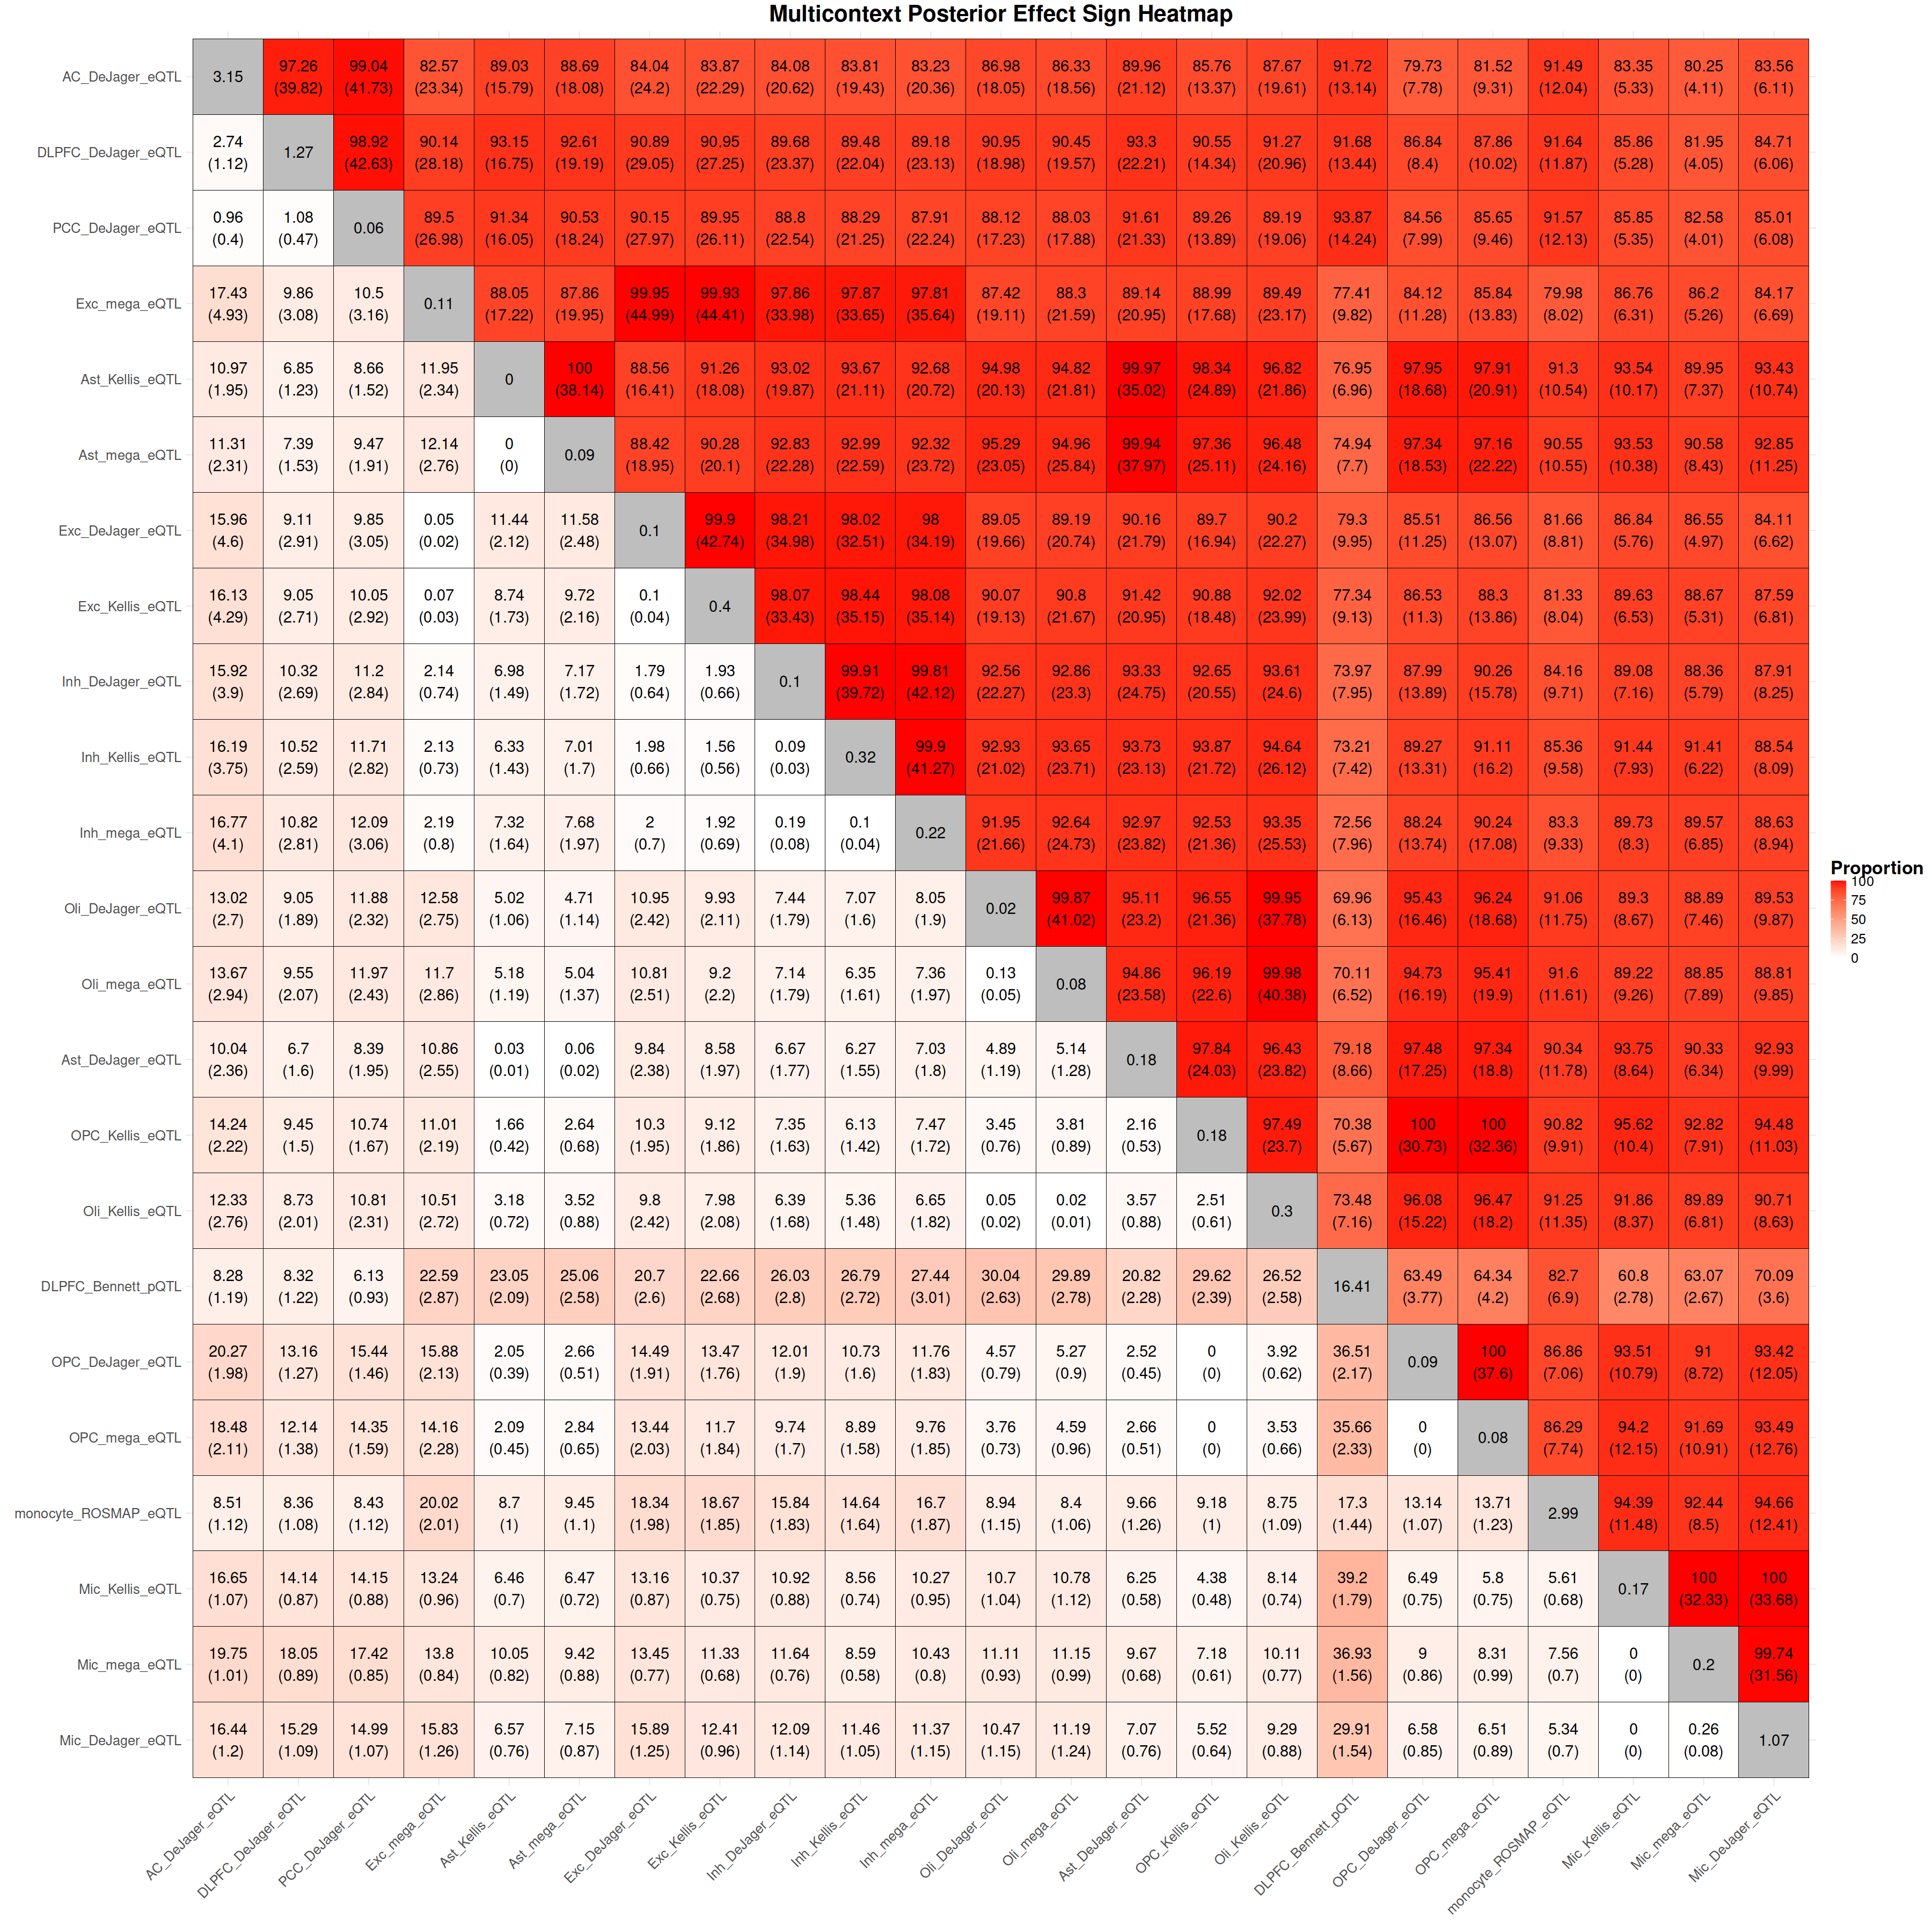

In [27]:
options(repr.plot.width = 30, repr.plot.height = 30)
p2